<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Bias correction of seasonal forecast data

### About

This notebook will show you how you can bias correct real-time seasonal forecasts of sea surface temperature. 

#### Model errors
Seasonal forecasts are started from an observed state of (all components of) the climate system, which is then evolved in time over a period of a few months. Errors present at the start of the forecast (due to the imprecise measurement of the initial conditions and the approximations assumed in the formulation of the models) persist or, more often, grow through the model integration.

#### Biases and hindcasts
Some errors are random, some errors, however, are systematic. If these systematic errors were determined, corrections could be applied to the forecasts to extract the useful information. This is achieved by comparing retrospective forecasts (reforecasts or `hindcasts`) with observations. By building average of the `hindcasts`, you can identify a 'climate' (average over a reference period, e.g 1993 to 2016) of the model, which can then be compared with the observed climate of the real world. The systematic differences between the model and the real world - usually referred to as `biases` - are thus quantified and used as the basis for corrections which can be applied to future, real-time forecasts.  Given the relative magnitude of such biases, some basic corrections are essential to convert the data into forecast information - therefore a forecast by itself is not useful without relating it to the relevant hindcasts.

To compute the real-world climate, the example below will make use of [ERA5 monthly averages on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).

#### Bias correction
TBA



The notebook has the following outline:

* [1 - Compute the hindcast climate mean and variance for reference period 1993 to 2016](#hindcast_climate_mean_bias)
* [2 - Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016](#observation_climate_mean_bias)
* [3 - Load real-time seasonal forecast for September 2021 and five leadtime months](#load_realtime_forecast_bias)
* [4 - Visualize the bias between seasonal real-time forecast, model climate and observed climate](#visualize_bias)
* [5 - Correct the real-time seasonal forecast](#bias_correction)

### Data

This notebook makes use of `seasonal forecast monthly statistics` (hindcasts and real-time forecasts) and `ERA5 monthly averaged data` on single levels. The data used in the notebook has the following specifications:

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Hindcast data` <br>
> **Temporal coverage**: `Sep 1993 to Sep 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve requests**: 
> * [CDS API request - Hindcast individual members](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast)
> * [CDS API request - Hindcast climate mean](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast_mean)

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Forecast data` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_forecast)

<br>

> **Data**: `ERA5 monthly averaged data on single levels` <br>
> **Temporal coverage**: `Sep, Oct, Nov, Dec, Jan and Feb from 1993 to 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly_seas5)

<br>

Get [here](./101_c3s_data_intro.ipynb#seasonal_forecasts) more information about seasonal forecast data in general including an overview of the different dataset types.

### Further resources

* [Seasonal forecasts and the Copernicus Climate Change Service](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service)

<br>

<hr>

### Load libraries

In [86]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='hindcast_climate_mean_bias'></a>1. Compute the hindcast climate mean and variance for reference period 1993 to 2016

The first step is load the global hindcast data for September from 1993 to 2016 and calculate the `mean` and `variance` of the hindcast climate, based on the reference period 1993 to 2016. 

The seasonal forecasts monthly statistics are available in the data format `GRIB`, which can be opened with the Python package [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. In order to be able to open `GRIB` file, you have to specify the keyword argument `engine='cfgrib'`, which makes use of [cfgrib](https://github.com/ecmwf/cfgrib), a Python interface to map GRIB to the NetCDF Common Data model.

Additionally, it is also recommended to use the keyword argument `backend_kwargs`, which allows you to tailor the structure of the `xarray.Dataset` to your analysis needs. For the following example, we would like to load `forecastMonth` and `time` as the two time dimension of the `xarray.Dataset`.

The loaded Dataset has five dimensions:

In [4]:
ds_hindcast = xr.open_dataset('./data/ecmwf_seas5_1993-2016_09_hindcast_monthly_sst.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_hindcast

<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-15T07:58 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load the data variable `sst` as `xarray.DataArray`. You can load a DataArray from a Dataset by specifying the name of the variable in square brackets `[]`. A `xarray.DataArray` provides you additional attributes of the variable. For example, you see that the sea surface temperature is provided in the unit `Kelvin`.

In [5]:
sst_hindcast = ds_hindcast['sst']
sst_hindcast

<xarray.DataArray 'sst' (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-09-01 1994-09-01 ... 2016-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

Since we are interested in creating the `hindcast climate mean`, the next step is to create the average over the 25 ensemble members and the 24 start years. You can use the function `mean()` in order to average over one or more given dimensions. The dimension we want to create the longterm mean are `number` (25 ensemble members) and `time` (start time years from 1993 to 2016). The result is a `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

The DataArray `tprate_hindcast_mean` is the hindcast climate mean for the month September and five leadtime months, over the reference period 1993 to 2016.

**Note:** with the averaging operation, your `xarray.DataArray` loses its attributes. Before the final visualisation of the computed anomalies ([here](#seas5_anomalies)), we will show you how to add and modify attributes of a xarray.DataArray.

In [6]:
sst_hindcast_mean = sst_hindcast.mean(['number', 'time'])
sst_hindcast_mean

<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[271.38278, 271.38278, 271.38278, ..., 271.38278, 271.38278,
         271.38278],
        [271.3829 , 271.383  , 271.38315, ..., 271.3826 , 271.38266,
         271.38284],
        [271.38742, 271.38782, 271.38818, ..., 271.3865 , 271.38678,
         271.38702],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34988, 271.34988, 271.34988, ..., 271.34988, 271.34988,
         271.34988],
        [271.35007, 271.35013, 271.35013, ..., 271.35007, 271.35007,
         271.35007],
        [271.35056, 271.35056, 271.35056, ..., 271.35056, 271.3506 ,
         271.3506 ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        [271.34967, 271.34967, 271.34967, ..., 271.34967, 271.34967,
         271.34967],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<br>

In [7]:
sst_hindcast_variance = sst_hindcast.var(['number', 'time'])
sst_hindcast_variance

/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


<xarray.DataArray 'sst' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[1.9864733e-03, 1.9864733e-03, 1.9864733e-03, ...,
         1.9864733e-03, 1.9864733e-03, 1.9864733e-03],
        [2.0455327e-03, 2.0600969e-03, 2.0772023e-03, ...,
         1.9969535e-03, 2.0109811e-03, 2.0267235e-03],
        [2.5749102e-03, 2.6136623e-03, 2.6538339e-03, ...,
         2.4352488e-03, 2.4787856e-03, 2.5270651e-03],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[4.9087776e-06, 4.9087776e-06, 4.9087776e-06, ...,
         4.9087776e-06, 4.9087776e-06, 4.9087776e-06],
        [8.8985144e-06, 8.7972858e-06, 8.7369854e-06, ...,
         8.8633469e-06, 8.8252000e-06, 8.9112300e-06],
        [2.9411360e-05, 2.8977536e-05, 2.8974557e-05, ...,
         2.9754205e-05, 2.9549599e-05, 2.9670397e-05],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        [3.7252903e-09, 3.7252903e-09, 3.7252903e-09, ...,
         3.7252903e-09, 3.7252903e-09, 3.7252903e-09],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

## <a id='observation_climate_mean_bias'></a>2. Compute observation climate mean and variance from ERA5 monthly averages for reference period 1993 to 2016

In [13]:
ds_observation = xr.open_dataset('./data/era5_monthly_1993-2016_sep-feb_sst.grib', engine='cfgrib')
ds_observation

2021-10-15 09:19:21,009 WARNING Ignoring index file './data/era5_monthly_1993-2016_sep-feb_sst.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (time: 144, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] ...
Data variables:
    sst         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-15T09:19 GRIB to CDM+CF via cfgrib-0.9.9...

In [14]:
sst_observation = ds_observation['sst']
sst_observation

<xarray.DataArray 'sst' (time: 144, latitude: 721, longitude: 1440)>
[149506560 values with dtype=float32]
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Attributes: (12/29)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

In [16]:
sst_observation_mean = sst_observation.groupby('time.month').mean()
sst_observation_mean

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[271.4601 , 271.4601 , 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.46008, 271.4601 , ..., 271.4601 , 271.4601 ,
         271.4601 ],
        [271.4601 , 271.4601 , 271.4601 , ..., 271.46008, 271.4601 ,
         271.4601 ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
        [271.46008, 271.46008, 271.46008, ..., 271.46008, 271.46008,
         271.46008],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        [271.45993, 271.45993, 271.45993, ..., 271.45993, 271.45993,
         271.45993],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

In [17]:
sst_observation_var = sst_observation.groupby('time.month').var()
sst_observation_var

/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.

<xarray.DataArray 'sst' (month: 6, latitude: 721, longitude: 1440)>
array([[[7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 6.95387499e-08, 7.97832982e-08, ...,
         7.97832982e-08, 7.97832982e-08, 7.97832982e-08],
        [7.97832982e-08, 7.97832982e-08, 7.97832982e-08, ...,
         1.09275184e-07, 7.97832982e-08, 7.97832982e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
        [8.44399111e-08, 8.44399111e-08, 8.44399111e-08, ...,
         8.44399111e-08, 8.44399111e-08, 8.44399111e-08],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        [6.86074273e-08, 6.86074273e-08, 6.86074273e-08, ...,
         6.86074273e-08, 6.86074273e-08, 6.86074273e-08],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * month      (month) int64 1 2 9 10 11 12

## <a id='load_realtime_forecast_bias'></a>3. Load real-time seasonal forecast for September 2021 and five leadtime months

In [18]:
ds_forecast = xr.open_dataset('./data/ecmwf_seas5_2021_09_forecast_monthly_sst.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    sst            (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-15T09:26 GRIB to CDM+CF via cfgrib-0.9.9...

In [21]:
sst_forecast = ds_forecast['sst']
sst_forecast

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
[19938960 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           sst
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

## <a id='visualize_bias'></a>4. Visualize the bias between seasonal real-time forecast, model climate and observed climate

In [22]:
sst_forecast_global = sst_forecast.mean(['latitude', 'longitude'])
sst_forecast_global

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6)>
array([[287.27606, 287.00058, 286.80887, 286.85257, 287.04587, 287.20447],
       [287.3017 , 287.0359 , 286.82843, 286.90076, 287.0865 , 287.26144],
       [287.25244, 286.98578, 286.80087, 286.83804, 287.09576, 287.26846],
       [287.28278, 287.02054, 286.83115, 286.85812, 287.05707, 287.23514],
       [287.29837, 286.99866, 286.80682, 286.91107, 287.1549 , 287.3256 ],
       [287.28336, 287.01822, 286.81967, 286.86655, 287.11356, 287.26572],
       [287.28046, 287.0128 , 286.79556, 286.85034, 287.06122, 287.19852],
       [287.26688, 287.02502, 286.815  , 286.849  , 287.0888 , 287.25183],
       [287.2802 , 287.02798, 286.8273 , 286.8588 , 287.08078, 287.25305],
       [287.3109 , 287.012  , 286.82965, 286.87744, 287.07028, 287.24857],
       [287.27313, 287.01202, 286.82632, 286.8792 , 287.09534, 287.27866],
       [287.25443, 286.99554, 286.8091 , 286.83798, 287.08795, 287.23413],
       [287.30118, 287.01016, 286.81207, 286.8703 , 287.0765 , 287.25046],
       [287.28098, 287.01285, 286.80017, 286.91382, 287.18784, 287.37134],
       [287.29462, 287.0136 , 286.8348 , 286.8731 , 287.11   , 287.26288],
       [287.2844 , 287.00912, 286.8458 , 286.88065, 287.0611 , 287.24817],
       [287.2813 , 287.00006, 286.83456, 286.8756 , 287.08792, 287.2392 ],
       [287.29614, 287.00742, 286.84753, 286.9231 , 287.13202, 287.2774 ],
       [287.2442 , 286.9949 , 286.7961 , 286.85135, 287.0529 , 287.1875 ],
       [287.27075, 287.00687, 286.82806, 286.84396, 287.04327, 287.21964],
...
       [287.28403, 287.0167 , 286.81897, 286.86755, 287.07584, 287.2278 ],
       [287.26678, 287.02267, 286.80984, 286.80344, 287.0817 , 287.23358],
       [287.29532, 287.01773, 286.84045, 286.86237, 287.03534, 287.2055 ],
       [287.2853 , 287.03076, 286.87305, 286.88504, 287.13867, 287.26535],
       [287.28607, 287.0248 , 286.82364, 286.85532, 287.06   , 287.20935],
       [287.28394, 287.0393 , 286.84744, 286.91086, 287.05972, 287.17096],
       [287.28986, 287.0404 , 286.84286, 286.87357, 287.086  , 287.22644],
       [287.2703 , 286.9966 , 286.8214 , 286.83914, 287.07224, 287.21463],
       [287.29022, 287.04257, 286.90436, 286.95023, 287.16052, 287.3188 ],
       [287.28134, 287.02194, 286.80753, 286.85687, 287.0904 , 287.24573],
       [287.27466, 287.00436, 286.825  , 286.91727, 287.12726, 287.27368],
       [287.27216, 287.01578, 286.80212, 286.86142, 287.0807 , 287.25314],
       [287.2805 , 286.99942, 286.8125 , 286.8788 , 287.08154, 287.26385],
       [287.2754 , 287.02267, 286.8124 , 286.84402, 287.08826, 287.2403 ],
       [287.27902, 287.00287, 286.81946, 286.8663 , 287.12222, 287.2441 ],
       [287.26398, 287.00983, 286.8045 , 286.8398 , 287.03052, 287.16846],
       [287.28198, 287.0026 , 286.82358, 286.81732, 287.01743, 287.20795],
       [287.2956 , 287.00745, 286.81937, 286.92886, 287.0917 , 287.2618 ],
       [287.2947 , 287.02414, 286.8565 , 286.89478, 287.168  , 287.31967]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0

In [25]:
model_climate_global = sst_hindcast_mean.mean(['latitude', 'longitude'])
model_climate_global

<xarray.DataArray 'sst' (forecastMonth: 6)>
array([287.05972, 286.80093, 286.6312 , 286.7019 , 286.93942, 287.1001 ],
      dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0

In [26]:
observed_climate_global = sst_observation_mean.mean(['latitude', 'longitude'])
observed_climate_global

<xarray.DataArray 'sst' (month: 6)>
array([286.8457 , 286.97427, 287.08298, 286.78787, 286.6294 , 286.67624],
      dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 1 2 9 10 11 12

In [48]:
observed_climate_global_roll = observed_climate_global.roll(month=4, roll_coords=True)
observed_climate_global_roll

<xarray.DataArray 'sst' (month: 6)>
array([287.08298, 286.78787, 286.6294 , 286.67624, 286.8457 , 286.97427],
      dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 9 10 11 12 1 2

In [49]:
observed_climate_global_assigned = observed_climate_global_roll.assign_coords(month=model_climate_global.forecastMonth.values)
observed_climate_global_assigned

<xarray.DataArray 'sst' (month: 6)>
array([287.08298, 286.78787, 286.6294 , 286.67624, 286.8457 , 286.97427],
      dtype=float32)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0
  * month    (month) int64 1 2 3 4 5 6

In [50]:
observed_climate_global_df = observed_climate_global_assigned.to_dataframe()
observed_climate_global_df

,number,step,surface,sst
month,,,,
1,0,0 days,0.0,287.082977
2,0,0 days,0.0,286.787872
3,0,0 days,0.0,286.629395
4,0,0 days,0.0,286.676239
5,0,0 days,0.0,286.845703
6,0,0 days,0.0,286.974274


In [44]:
model_climate_global_df = model_climate_global.to_dataframe()
model_climate_global_df

,surface,sst
forecastMonth,,
1,0.0,287.059723
2,0.0,286.800934
3,0.0,286.631195
4,0.0,286.701904
5,0.0,286.939423
6,0.0,287.100098


In [56]:
sst_forecast_global

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6)>
array([[287.27606, 287.00058, 286.80887, 286.85257, 287.04587, 287.20447],
       [287.3017 , 287.0359 , 286.82843, 286.90076, 287.0865 , 287.26144],
       [287.25244, 286.98578, 286.80087, 286.83804, 287.09576, 287.26846],
       [287.28278, 287.02054, 286.83115, 286.85812, 287.05707, 287.23514],
       [287.29837, 286.99866, 286.80682, 286.91107, 287.1549 , 287.3256 ],
       [287.28336, 287.01822, 286.81967, 286.86655, 287.11356, 287.26572],
       [287.28046, 287.0128 , 286.79556, 286.85034, 287.06122, 287.19852],
       [287.26688, 287.02502, 286.815  , 286.849  , 287.0888 , 287.25183],
       [287.2802 , 287.02798, 286.8273 , 286.8588 , 287.08078, 287.25305],
       [287.3109 , 287.012  , 286.82965, 286.87744, 287.07028, 287.24857],
       [287.27313, 287.01202, 286.82632, 286.8792 , 287.09534, 287.27866],
       [287.25443, 286.99554, 286.8091 , 286.83798, 287.08795, 287.23413],
       [287.30118, 287.01016, 286.81207, 286.8703 , 287.0765 , 287.25046],
       [287.28098, 287.01285, 286.80017, 286.91382, 287.18784, 287.37134],
       [287.29462, 287.0136 , 286.8348 , 286.8731 , 287.11   , 287.26288],
       [287.2844 , 287.00912, 286.8458 , 286.88065, 287.0611 , 287.24817],
       [287.2813 , 287.00006, 286.83456, 286.8756 , 287.08792, 287.2392 ],
       [287.29614, 287.00742, 286.84753, 286.9231 , 287.13202, 287.2774 ],
       [287.2442 , 286.9949 , 286.7961 , 286.85135, 287.0529 , 287.1875 ],
       [287.27075, 287.00687, 286.82806, 286.84396, 287.04327, 287.21964],
...
       [287.28403, 287.0167 , 286.81897, 286.86755, 287.07584, 287.2278 ],
       [287.26678, 287.02267, 286.80984, 286.80344, 287.0817 , 287.23358],
       [287.29532, 287.01773, 286.84045, 286.86237, 287.03534, 287.2055 ],
       [287.2853 , 287.03076, 286.87305, 286.88504, 287.13867, 287.26535],
       [287.28607, 287.0248 , 286.82364, 286.85532, 287.06   , 287.20935],
       [287.28394, 287.0393 , 286.84744, 286.91086, 287.05972, 287.17096],
       [287.28986, 287.0404 , 286.84286, 286.87357, 287.086  , 287.22644],
       [287.2703 , 286.9966 , 286.8214 , 286.83914, 287.07224, 287.21463],
       [287.29022, 287.04257, 286.90436, 286.95023, 287.16052, 287.3188 ],
       [287.28134, 287.02194, 286.80753, 286.85687, 287.0904 , 287.24573],
       [287.27466, 287.00436, 286.825  , 286.91727, 287.12726, 287.27368],
       [287.27216, 287.01578, 286.80212, 286.86142, 287.0807 , 287.25314],
       [287.2805 , 286.99942, 286.8125 , 286.8788 , 287.08154, 287.26385],
       [287.2754 , 287.02267, 286.8124 , 286.84402, 287.08826, 287.2403 ],
       [287.27902, 287.00287, 286.81946, 286.8663 , 287.12222, 287.2441 ],
       [287.26398, 287.00983, 286.8045 , 286.8398 , 287.03052, 287.16846],
       [287.28198, 287.0026 , 286.82358, 286.81732, 287.01743, 287.20795],
       [287.2956 , 287.00745, 286.81937, 286.92886, 287.0917 , 287.2618 ],
       [287.2947 , 287.02414, 286.8565 , 286.89478, 287.168  , 287.31967]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-09-01
    surface        float64 0.0

In [61]:
sst_forecast_global.drop_vars(['time', 'surface'])

<xarray.DataArray 'sst' (number: 51, forecastMonth: 6)>
array([[287.27606, 287.00058, 286.80887, 286.85257, 287.04587, 287.20447],
       [287.3017 , 287.0359 , 286.82843, 286.90076, 287.0865 , 287.26144],
       [287.25244, 286.98578, 286.80087, 286.83804, 287.09576, 287.26846],
       [287.28278, 287.02054, 286.83115, 286.85812, 287.05707, 287.23514],
       [287.29837, 286.99866, 286.80682, 286.91107, 287.1549 , 287.3256 ],
       [287.28336, 287.01822, 286.81967, 286.86655, 287.11356, 287.26572],
       [287.28046, 287.0128 , 286.79556, 286.85034, 287.06122, 287.19852],
       [287.26688, 287.02502, 286.815  , 286.849  , 287.0888 , 287.25183],
       [287.2802 , 287.02798, 286.8273 , 286.8588 , 287.08078, 287.25305],
       [287.3109 , 287.012  , 286.82965, 286.87744, 287.07028, 287.24857],
       [287.27313, 287.01202, 286.82632, 286.8792 , 287.09534, 287.27866],
       [287.25443, 286.99554, 286.8091 , 286.83798, 287.08795, 287.23413],
       [287.30118, 287.01016, 286.81207, 286.8703 , 287.0765 , 287.25046],
       [287.28098, 287.01285, 286.80017, 286.91382, 287.18784, 287.37134],
       [287.29462, 287.0136 , 286.8348 , 286.8731 , 287.11   , 287.26288],
       [287.2844 , 287.00912, 286.8458 , 286.88065, 287.0611 , 287.24817],
       [287.2813 , 287.00006, 286.83456, 286.8756 , 287.08792, 287.2392 ],
       [287.29614, 287.00742, 286.84753, 286.9231 , 287.13202, 287.2774 ],
       [287.2442 , 286.9949 , 286.7961 , 286.85135, 287.0529 , 287.1875 ],
       [287.27075, 287.00687, 286.82806, 286.84396, 287.04327, 287.21964],
...
       [287.28403, 287.0167 , 286.81897, 286.86755, 287.07584, 287.2278 ],
       [287.26678, 287.02267, 286.80984, 286.80344, 287.0817 , 287.23358],
       [287.29532, 287.01773, 286.84045, 286.86237, 287.03534, 287.2055 ],
       [287.2853 , 287.03076, 286.87305, 286.88504, 287.13867, 287.26535],
       [287.28607, 287.0248 , 286.82364, 286.85532, 287.06   , 287.20935],
       [287.28394, 287.0393 , 286.84744, 286.91086, 287.05972, 287.17096],
       [287.28986, 287.0404 , 286.84286, 286.87357, 287.086  , 287.22644],
       [287.2703 , 286.9966 , 286.8214 , 286.83914, 287.07224, 287.21463],
       [287.29022, 287.04257, 286.90436, 286.95023, 287.16052, 287.3188 ],
       [287.28134, 287.02194, 286.80753, 286.85687, 287.0904 , 287.24573],
       [287.27466, 287.00436, 286.825  , 286.91727, 287.12726, 287.27368],
       [287.27216, 287.01578, 286.80212, 286.86142, 287.0807 , 287.25314],
       [287.2805 , 286.99942, 286.8125 , 286.8788 , 287.08154, 287.26385],
       [287.2754 , 287.02267, 286.8124 , 286.84402, 287.08826, 287.2403 ],
       [287.27902, 287.00287, 286.81946, 286.8663 , 287.12222, 287.2441 ],
       [287.26398, 287.00983, 286.8045 , 286.8398 , 287.03052, 287.16846],
       [287.28198, 287.0026 , 286.82358, 286.81732, 287.01743, 287.20795],
       [287.2956 , 287.00745, 286.81937, 286.92886, 287.0917 , 287.2618 ],
       [287.2947 , 287.02414, 286.8565 , 286.89478, 287.168  , 287.31967]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6

In [75]:
sst_forecast_global_df = sst_forecast_global.drop_vars(['surface','time']).to_dataframe(dim_order=['forecastMonth', 'number'])
sst_forecast_global_df


sst
forecastMonth number            
1             0       287.276062
              1       287.301697
              2       287.252441
              3       287.282776
              4       287.298370
...                          ...
6             46      287.244110
              47      287.168457
              48      287.207947
              49      287.261810
              50      287.319672

[306 rows x 1 columns]

In [77]:
sst_forecast_global_df_final = sst_forecast_global_df.unstack()
sst_forecast_global_df_final

sst                                                  \
number                 0           1           2           3           4    
forecastMonth                                                               
1              287.276062  287.301697  287.252441  287.282776  287.298370   
2              287.000580  287.035889  286.985779  287.020538  286.998657   
3              286.808868  286.828430  286.800873  286.831146  286.806824   
4              286.852570  286.900757  286.838043  286.858124  286.911072   
5              287.045868  287.086487  287.095764  287.057068  287.154907   
6              287.204468  287.261444  287.268463  287.235138  287.325592   

                                                                           \
number                 5           6           7           8           9    
forecastMonth                                                               
1              287.283356  287.280457  287.266876  287.280212  287.310913   
2              287.018219  287.012787  287.025024  287.027985  287.011993   
3              286.819672  286.795563  286.815002  286.827301  286.829651   
4              286.866547  286.850342  286.848999  286.858795  286.877441   
5              287.113556  287.061218  287.088806  287.080780  287.070282   
6              287.265717  287.198517  287.251831  287.253052  287.248566   

               ...                                                  \
number         ...          41          42          43          44   
forecastMonth  ...                                                   
1              ...  287.281342  287.274658  287.272156  287.280487   
2              ...  287.021942  287.004364  287.015778  286.999420   
3              ...  286.807526  286.825012  286.802124  286.812500   
4              ...  286.856873  286.917267  286.861420  286.878815   
5              ...  287.090393  287.127258  287.080688  287.081543   
6              ...  287.245728  287.273682  287.253143  287.263855   

                                                                           \
number                 45          46          47          48          49   
forecastMonth                                                               
1              287.275391  287.279022  287.263977  287.281982  287.295593   
2              287.022675  287.002869  287.009827  287.002594  287.007446   
3              286.812408  286.819458  286.804504  286.823578  286.819366   
4              286.844025  286.866302  286.839813  286.817322  286.928864   
5              287.088257  287.122223  287.030518  287.017426  287.091705   
6              287.240295  287.244110  287.168457  287.207947  287.261810   

                           
number                 50  
forecastMonth              
1              287.294708  
2              287.024139  
3              286.856506  
4              286.894775  
5              287.167999  
6              287.319672  

[6 rows x 51 columns]

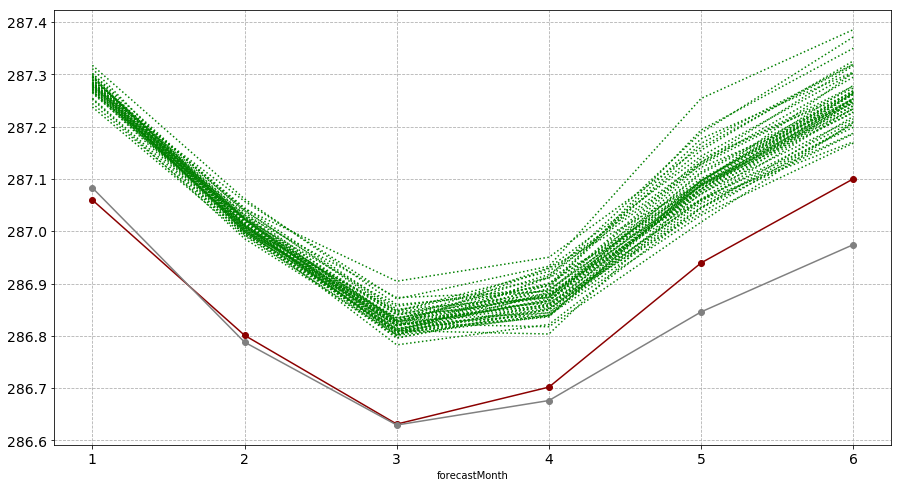

In [85]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(model_climate_global_df.sst, 'bo-', color='darkred', label='Model climate')
ax.plot(observed_climate_global_df.sst, 'bo-', color='grey', label= 'Observed climate')

sst_forecast_global_df_final.plot(ax=ax,
                             linestyle='dotted', color='green', legend=False)

ax.plot()

# Customize the title and axes lables
#ax.set_title('\n'+era5_t2m_max_2020_lille.long_name+'\n', fontsize=20)
#ax.set_ylabel(era5_t2m_max_2020_lille.units, fontsize=14)
#ax.set_xlabel('\nday', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

<br>

## <a id='bias_correction'></a>5. Correct the real-time seasonal forecast

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>